#TASK 1 ROBERTA BASELINE EVAL

In [ ]:
!pip install pytorch-lightning sentence-transformers torchmetrics rich

In [ ]:
! cp -r /content/drive/MyDrive/synthetic-squad .

^C


In [ ]:
!ls -la ..

total 100
drwxr-xr-x   1 root root  4096 May  8 05:58 .
drwxr-xr-x   1 root root  4096 May  8 05:58 ..
lrwxrwxrwx   1 root root     7 Jan 26 08:26 bin -> usr/bin
drwxr-xr-x   2 root root  4096 Apr 15  2020 boot
drwxr-xr-x   1 root root  4096 May  8 06:47 content
drwxr-xr-x   1 root root  4096 May  3 13:46 datalab
drwxr-xr-x   6 root root   460 May  8 05:59 dev
-rwxr-xr-x   1 root root     0 May  8 05:58 .dockerenv
drwxr-xr-x   1 root root  4096 May  8 05:58 etc
drwxr-xr-x   2 root root  4096 Apr 15  2020 home
lrwxrwxrwx   1 root root     7 Jan 26 08:26 lib -> usr/lib
lrwxrwxrwx   1 root root     9 Jan 26 08:26 lib32 -> usr/lib32
lrwxrwxrwx   1 root root     9 Jan 26 08:26 lib64 -> usr/lib64
lrwxrwxrwx   1 root root    10 Jan 26 08:26 libx32 -> usr/libx32
drwxr-xr-x   2 root root  4096 Jan 26 08:26 media
drwxr-xr-x   2 root root  4096 Jan 26 08:26 mnt
-rw-r--r--   1 root root 16047 Feb  2 05:18 NGC-DL-CONTAINER-LICENSE
drwxr-xr-x   1 root root  4096 May  8 05:58 opt
dr-xr-xr-x 194 root 

In [ ]:
import os

os.chdir('/content/drive/MyDrive/synthetic-squad/src')
os.getcwd()

'/content/drive/MyDrive/synthetic-squad/src'

In [ ]:
import sklearn
from sklearn.metrics import classification_report
import pandas as pd
from datautils import SynDataModule, SynBatcher
from utils import get_data_task1

from modelling import SequenceClassification
from pytorch_lightning.callbacks import(
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary
)
from pytorch_lightning import Trainer, seed_everything
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
TASK = 3
DPATH = r'/content/drive/MyDrive/synthetic-squad/data/new_punc_data_eval.csv'
D2PATH = r'/content/drive/MyDrive/synthetic-squad/data/liwc_pos_dep_reddit.csv'
MPATH = "roberta-base"

df_aa_paper = pd.read_csv(DPATH)

df_reddit = pd.read_csv(D2PATH)

label2id = {'human': 0,
 'fair': 1,
 'grover': 2,
 'gpt2': 3,
 'gpt3': 4,
 'instructgpt': 5,
 'gpt': 6,
 'ctrl': 7,
 'pplm': 8,
 'xlnet': 9,
 'xlm': 10}

In [ ]:
label2id

{'human': 0,
 'fair': 1,
 'grover': 2,
 'gpt2': 3,
 'gpt3': 4,
 'instructgpt': 5,
 'gpt': 6,
 'ctrl': 7,
 'pplm': 8,
 'xlnet': 9,
 'xlm': 10}

In [ ]:
def print_metric_task1(pred_df, label2id, model_path, source="aa_paper", batch_size=20):
  df_source = pred_df
  eval_df = get_data_task1(df_source, 20)
  idx_set = set(eval_df.first_idx.to_list() + eval_df.second_idx.to_list())
  filtered_df = pred_df[pred_df.index.isin(idx_set)]
  filtered_df.to_csv("/tmp/filtered_df.csv", index=False)
  batcher = SynBatcher(tnkzr_path=MPATH,has_targets=False)
  eval_dm = SynDataModule(data_path="/tmp/filtered_df.csv", task='same', label2id=label2id, batcher=batcher, srcs_to_keep=[source])

  SAVE_PATH = "roberta-base"

# model = SequenceClassification(MPATH, num_labels=len(label2id))
# print("Loaded fresh model")

  model = SequenceClassification.load_from_checkpoint(model_path)

  checkpoint_callback = ModelCheckpoint(
      SAVE_PATH,
      filename=f'task-{TASK}-{{epoch}}-{{val_loss:.2f}}',
      monitor='val_loss',
      save_weights_only=True,
  )
  early_stop_callback = EarlyStopping(
      monitor="val_loss",
      min_delta=1e-4, patience=8,
      verbose=False,
      mode="min"
  )

  seed_everything(42, workers=True)

  trainer = Trainer(
      max_epochs=-1,
      deterministic=True,
      accumulate_grad_batches=4,
      callbacks=[checkpoint_callback, early_stop_callback, RichModelSummary()],
      accelerator='gpu',
      log_every_n_steps=16
  )
  preds = trainer.predict(model,eval_dm)
  indices = [i[0].reshape(len(i[0]), 1) for i in preds]
  pred_labels = [i[1].reshape(len(i[1]), 1) for i in preds]

  filtered_df["pred"] = np.vstack(pred_labels)

  id2label = {id: alg for alg, id in label2id.items()}

  eval_df["pred_labels"] = eval_df[["first_idx", "second_idx"]].apply(lambda x: (id2label[filtered_df.loc[x[0]]['pred']], id2label[filtered_df.loc[x[1]]['pred']]), axis=1)
  eval_df["pred"] = eval_df["pred_labels"].apply(lambda x: "Same" if x[0] == x[1] else "Not Same")

  print(classification_report(eval_df["ground_truth"], eval_df["pred"]))

  # example ground truth and predictions
  y_true = eval_df["ground_truth"].to_list()
  y_pred = eval_df["pred"].to_list()

  # create the confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # plot the confusion matrix
  classes = ["Same", "Not Same"]
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  thresh = cm.max() / 2.
  for i, j in np.ndindex(cm.shape):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

  return eval_df



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

Predicting: 0it [00:00, ?it/s]

<ipython-input-5-5906125f8489>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = np.vstack(pred_labels)


              precision    recall  f1-score   support

    Not Same       0.99      0.99      0.99     22000
        Same       0.87      0.88      0.88      2090

    accuracy                           0.98     24090
   macro avg       0.93      0.94      0.93     24090
weighted avg       0.98      0.98      0.98     24090



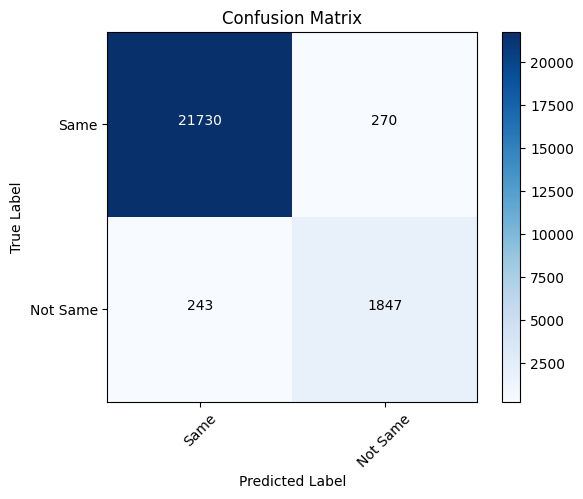

,first_idx,second_idx,true_labels,ground_truth,pred_labels,pred
0,600,201,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
1,600,996,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
2,600,667,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
3,600,208,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
4,600,343,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
...,...,...,...,...,...,...
24085,956,1199,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24086,956,64,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24087,1207,1199,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24088,1207,64,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same


In [ ]:
print_metric_task1(df_aa_paper, label2id, "/content/drive/MyDrive/synthetic-squad/models/task3/roberta-base/task-3-epoch=1-val_loss=0.19.ckpt")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

Predicting: 0it [00:00, ?it/s]

<ipython-input-5-5906125f8489>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = np.vstack(pred_labels)


              precision    recall  f1-score   support

    Not Same       0.77      0.76      0.77      1200
        Same       0.51      0.53      0.52       570

    accuracy                           0.68      1770
   macro avg       0.64      0.64      0.64      1770
weighted avg       0.69      0.68      0.69      1770



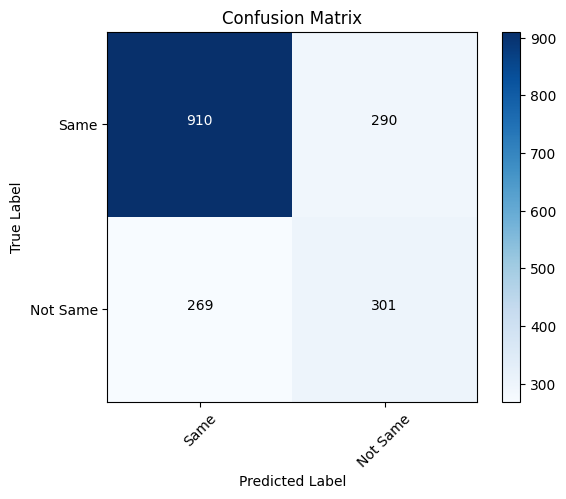

,first_idx,second_idx,true_labels,ground_truth,pred_labels,pred
0,928,1272,"(gpt3, gpt3)",Same,"(instructgpt, gpt3)",Not Same
1,928,1522,"(gpt3, gpt3)",Same,"(instructgpt, gpt3)",Not Same
2,928,1623,"(gpt3, gpt3)",Same,"(instructgpt, instructgpt)",Same
3,928,1763,"(gpt3, gpt3)",Same,"(instructgpt, instructgpt)",Same
4,928,1723,"(gpt3, gpt3)",Same,"(instructgpt, instructgpt)",Same
...,...,...,...,...,...,...
1765,2540,1773,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same
1766,2540,2032,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same
1767,2629,1773,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same
1768,2629,2032,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same


In [ ]:
print_metric_task1(df_reddit[["title",	"generation", "alg","src"]], label2id, "/content/drive/MyDrive/synthetic-squad/models/task3/roberta-base/task-3-epoch=1-val_loss=0.19.ckpt", source="reddit")

,title,generation,alg,src
0,Where does the water go when drought happens ?,There currently seems to be a lot of drought e...,human,reddit
1,how does the process of remembering something ...,Sometimes I think about a name for example an ...,human,reddit
2,What makes coffee so special to you?,I'm trying to understand exactly what it is t...,human,reddit
3,modem and router question.,I'm confused with this stuff. So my isp'ed mod...,human,reddit
4,Why can’t we save endangered animals through c...,Saw a post about the last two remaining White ...,human,reddit
...,...,...,...,...
2639,(23m) have no idea what even happening with my...,\r\n\r\nYou are an amazing human being. I high...,instructgpt,reddit
2640,Do I owe him my support even if it is intensel...,\r\n\r\nIf you are persistently being confront...,instructgpt,reddit
2641,My [29F] boyfriend [34M] and I can't agree on ...,"I have a job offer in California, he has a jo...",instructgpt,reddit
2642,"(27f) am in love with my (34m) boyfriend, but ...","🙁\r\n\r\nEmma is in love with her boyfriend, a...",instructgpt,reddit
